In [ ]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', None)

In [ ]:
excel_data_df = pd.ExcelFile(r'../data/nha.xlsx')
excel_data_df = excel_data_df.parse(excel_data_df.sheet_names[1])

In [ ]:
result_df = pd.ExcelFile(r'../data/nha-result.xlsx')
result_df = result_df.parse(result_df.sheet_names[0])
result_set = result_df.iloc[:, 1].tolist()

In [ ]:
for idx, header in enumerate(excel_data_df.columns.tolist()):
    print(idx, header)

In [ ]:
# excel_data_df = excel_data_df[(excel_data_df["11. Bạn mong muốn tham gia vào ban"] == "Nhân sự")]
# excel_data_df = excel_data_df[(excel_data_df["11. Bạn mong muốn tham gia vào ban"] == "Đối ngoại")]
# excel_data_df = excel_data_df[(excel_data_df["11. Bạn mong muốn tham gia vào ban"] == "Chuyên môn")]
excel_data_df.reset_index(drop=True, inplace=True)
excel_data_df.fillna("", inplace = True)
# filter = [0, 1, 5, 7, 9, 11, 14, 15, 16, 17, 18, 19, 22, 23, 24, 26, 28, 30, 31, 33, 34, 35, 36, 37, 40, 41, 43, 44, 45, 52, 53, 55, 58, 60, 61, 65, 68, 69, 74, 77, 84, 86, 87, 88, 89, 96, 97, 98, 102, 104, 106, 107, 108, 110, 111, 112, 113, 114, 116, 117, 120, 127, 129, 134, 135, 137, 138, 139, 140, 140, 142, 145, 146, 149, 152, 154, 155]
# excel_data_df = excel_data_df.iloc[filter]
# excel_data_df.reset_index(drop=True, inplace=True)
# identity = list(excel_data_df.index.values)
identity = excel_data_df.iloc[:, 1].tolist()

In [ ]:
import sys; sys.path.insert(0, '..')
from app.loader import loader
from app.ssmc_fcm import SSMC_FCM

In [ ]:
fields_chosen = {
    # # egg data
    # 3: (loader.multilabel_binarizing, 1),
    # 4: (loader.multilabel_binarizing, 1),
    # 5: (loader.feature_engineering, 1),
    # 6: (loader.feature_engineering, 1),
    # 7: (loader.multilabel_binarizing, 1),
    # 8: (loader.multilabel_binarizing, 1),
    # 9: (loader.multilabel_binarizing, 1),
    # 10: (loader.feature_engineering, 1),

    # nha data
    40: (loader.feature_engineering, 1),
    43: (loader.feature_engineering, 1),
    46: (loader.feature_engineering, 1),
    49: (loader.feature_engineering, 1),
    55: (loader.feature_engineering, 1),
    58: (loader.feature_engineering, 1),
}

In [ ]:
from datetime import datetime
vectors = {}
for id_field, config in fields_chosen.items():
    start = datetime.now()
    func = config[0]
    raw_data = excel_data_df.iloc[:, id_field].tolist()
    data = func(raw_data)
    vectors[id_field] = data
    print(f"{round(100 * (list(fields_chosen).index(id_field) + 1) / len(fields_chosen), 2)}% ({datetime.now() - start})")

In [118]:
cluster_fields = [
    40,
    43,
    46,
    49,
    55,
    58,
]
dataset = None
data_field_len = []
data_field_weight = []
for idx, id_field in enumerate(cluster_fields):
    data = np.array(vectors[id_field])
    dataset = data if idx == 0 else np.hstack((dataset, data))
    data_field_len.append(data.shape[1])
    data_field_weight.append(fields_chosen[id_field][1])
dataset.shape, data_field_len, data_field_weight

((106, 4608), [768, 768, 768, 768, 768, 768], [1, 1, 1, 1, 1, 1])

Supervised percentage: 5.66% (6:106)
Cluster members: 
[14, 14, 16, 20, 24, 28, 41, 45, 49, 52, 53, 54, 78, 82, 88, 93, 95, 101, 103, 106, 113, 115, 120, 124, 125, 133, 134, 135, 136, 139, 140, 144, 152, 155, 156, 166, 168, 171, 172, 173, 175, 181, 182, 183, 188, 191, 200, 202, 211, 212, 216, 222, 226, 224, 235, 237, 238, 239, 246, 247]
[11, 12, 13, 15, 21, 22, 25, 34, 37, 38, 40, 61, 62, 63, 67, 68, 75, 79, 81, 91, 97, 99, 109, 111, 121, 130, 132, 137, 145, 148, 149, 153, 154, 158, 163, 167, 178, 185, 189, 195, 201, 228, 232, 241]
[87]
[]
[105]


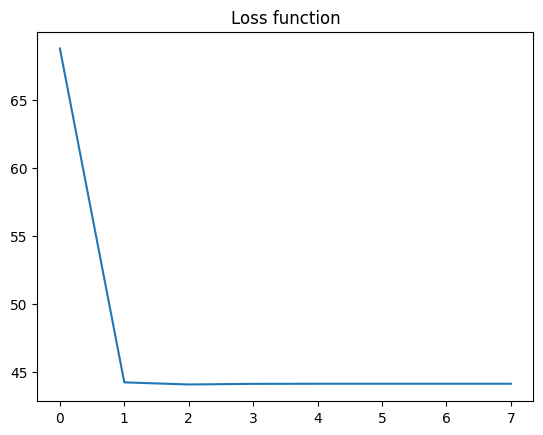

loss functions: 
[68.76077411403612, 44.25150535598299, 44.09620208317722, 44.142890157731756, 44.14893580579863, 44.150015680013084, 44.15020876079247, 44.15023862286855]


In [117]:
supervised_set = [
    [
        20,
        41,
        45,
        49,
        52,
        53,
    ]
]
ssmc_fcm = SSMC_FCM(
    dataset=dataset, 
    fields_len=data_field_len, 
    fields_weight=[1, 0, 1, 0, 3, 0],
    n_clusters=5, 
    identity=identity,
    supervised_set=supervised_set, 
)
ssmc_fcm.clustering()
ssmc_fcm.show_cluster_members()
ssmc_fcm.show_loss_function()

In [116]:
identity_mapping = {iden: idx for idx, iden in enumerate(identity)}
for cluster in ssmc_fcm.pred_labels:
    count = sum([cluster.count(x) for x in result_set])
    print(f"Accuracy: {round(100 * count / len(result_set), 2)}% ({count} in {len(cluster)} of {len(ssmc_fcm.dataset)})")
    # print([identity.index(i) for i in cluster])
    # display(excel_data_df.loc[[identity.index(i) for i in cluster]].iloc[:, [1, *cluster_fields]])

Accuracy: 84.0% (42 in 60 of 106)
Accuracy: 14.0% (7 in 44 of 106)
Accuracy: 0.0% (0 in 1 of 106)
Accuracy: 0.0% (0 in 0 of 106)
Accuracy: 0.0% (0 in 1 of 106)
